In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# from model import encoder, decoder
from tqdm import tqdm

In [4]:
class Debug:
    pass

debug = Debug()

In [5]:
def res_block(inputs, filters, kernel_size, strides=(1, 1), kernel_initializer=None):
    x = inputs

    x = tf.layers.conv2d(x, filters, kernel_size=kernel_size, strides=strides, padding="same", kernel_initializer=kernel_initializer)
    x = tf.layers.batch_normalization(x, axis=3, epsilon=1e-5, momentum=0.1, training=True, gamma_initializer=kernel_initializer)
    x = tf.nn.relu(x)

    x = tf.layers.conv2d(x, filters, kernel_size=kernel_size, strides=strides, padding="same", kernel_initializer=kernel_initializer)
    x = tf.layers.batch_normalization(x, axis=3, epsilon=1e-5, momentum=0.1, training=True, gamma_initializer=kernel_initializer)
    x = tf.nn.relu(x + inputs)

    return x


def encoder(inputs):
    x = inputs
    h = 128
    latent_dim = 128
    initializer = tf.random_normal_initializer(0, 0.02)

    # -------
    x = tf.layers.conv2d(x, h, kernel_size=5, strides=(1, 1), padding="same", kernel_initializer=initializer)
    x = tf.layers.average_pooling2d(x, 2, 2, padding='same')
    x = tf.nn.relu(x)

    # -------
    x = res_block(x, h, kernel_size=3, kernel_initializer=initializer)
    x = tf.layers.average_pooling2d(x, 2, 2, padding='same')

    # -------
    x = res_block(x, h, kernel_size=3, kernel_initializer=initializer)
    x = tf.layers.average_pooling2d(x, 2, 2, padding='same')

    # -------
    x = res_block(x, h, kernel_size=3, kernel_initializer=initializer)

    # -------
    x = tf.reshape(x, shape=(-1, h * 4 * 4))
    x = tf.layers.dense(x, latent_dim, kernel_initializer=initializer)

    return x



def decoder(inputs):
    h = 128
    initializer = tf.random_normal_initializer(0, 0.02)

    x = tf.layers.dense(inputs, h * 4 * 4, kernel_initializer=initializer)
    x = tf.reshape(x, shape=(-1, 4, 4, h))
    x = tf.nn.relu(x)

    # -------
    x = res_block(x, h, kernel_size=3, kernel_initializer=initializer)
    x = tf.image.resize_nearest_neighbor(x, (x.shape[1] * 2, x.shape[2] * 2))

    # -------
    x = res_block(x, h, kernel_size=3, kernel_initializer=initializer)
    x = tf.image.resize_nearest_neighbor(x, (x.shape[1] * 2, x.shape[2] * 2))

    # -------
    x = res_block(x, h, kernel_size=3, kernel_initializer=initializer)
    x = tf.image.resize_nearest_neighbor(x, (x.shape[1] * 2, x.shape[2] * 2))

    # -------
    x = res_block(x, h, kernel_size=3, kernel_initializer=initializer)
    x = tf.layers.conv2d(x, 1, kernel_size=1, padding="same", kernel_initializer=initializer)

    x = tf.nn.tanh(x)

    return x


In [6]:
inputs = tf.placeholder(tf.float32, (None, 32, 32, 1))

In [7]:
x = (inputs / 255.0) * 2 - 1

In [8]:
z = encoder(x)

In [9]:
y = decoder(z)

In [10]:
y

<tf.Tensor 'Tanh:0' shape=(?, 32, 32, 1) dtype=float32>

In [11]:
loss = tf.reduce_mean(tf.pow(x - y, 2))

In [12]:
optimize = tf.train.AdamOptimizer().minimize(loss)

In [13]:
# data load

import numpy as np
data = np.load('data/cat_32.npy')

# data = (data / 255.0) * 2 - 1
data = data[:1024]

In [14]:
data.shape

(1024, 32, 32, 1)

In [15]:
init = tf.global_variables_initializer()
sess = tf.Session()

In [16]:
sess.run(init)

In [17]:
batch_size = 128
max_epoch = 5

saver = tf.train.Saver()

for epoch in range(max_epoch):
    for index in tqdm(range(0, len(data), batch_size)):
        batch = data[index:index+batch_size]
        _, current_loss = sess.run([optimize, loss], {inputs: batch})
#     saver.save(sess, './model/model', global_step=epoch)    
    print("epoch:", epoch+1, ", loss:", current_loss)
    
    
#         print(ret)
# sess.run(loss, {inputs: data})

 12%|█▎        | 1/8 [00:00<00:00,  9.12it/s]

epoch: 1 , loss: 0.553684


 12%|█▎        | 1/8 [00:00<00:00,  9.17it/s]

epoch: 2 , loss: 0.5218158


 12%|█▎        | 1/8 [00:00<00:00,  9.31it/s]

epoch: 3 , loss: 0.50194


 12%|█▎        | 1/8 [00:00<00:00,  9.24it/s]

epoch: 4 , loss: 0.47950202


100%|██████████| 8/8 [00:00<00:00,  9.14it/s]

epoch: 5 , loss: 0.4574715


In [18]:
image = data[3]

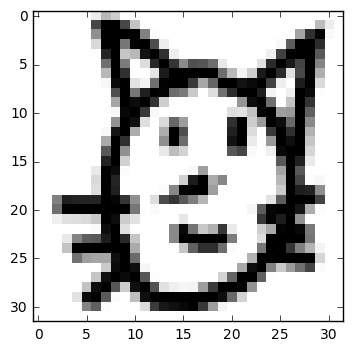

In [19]:
plt.imshow(image[:, :, 0], cmap='gray', interpolation='nearest')

In [20]:
decoded = sess.run(y, {inputs: [image]})

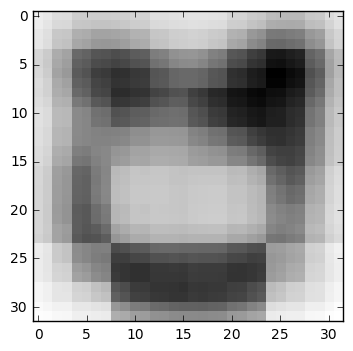

In [21]:
plt.imshow(decoded[0, :, :].mean(-1), cmap='gray', interpolation='nearest')